In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

print(tf.__version__)

0.12.0-rc0


## Downloading and loading playlists and songs metadata

See http://www.cs.cornell.edu/~shuochen/lme/data_page.html

In [4]:
!wget http://www.cs.cornell.edu/~shuochen/lme/dataset.tar.gz
! tar -xvf dataset.tar.gz

--2017-01-06 16:13:07--  http://www.cs.cornell.edu/~shuochen/lme/dataset.tar.gz
Resolving www.cs.cornell.edu... 132.236.207.20
Connecting to www.cs.cornell.edu|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15344424 (15M) [application/x-gzip]
Saving to: 'dataset.tar.gz.4'

dataset.tar.gz.4    100%[=====================>]  14.63M  1.85MB/s   in 8.3s   

2017-01-06 16:13:16 (1.76 MB/s) - 'dataset.tar.gz.4' saved [15344424/15344424]

x dataset/
x dataset/._.DS_Store
x dataset/.DS_Store
x dataset/README
x dataset/yes_big/
x dataset/yes_complete/
x dataset/yes_small/
x dataset/yes_small/song_hash.txt
x dataset/yes_small/tag_hash.txt
x dataset/yes_small/tags.txt
x dataset/yes_small/test.txt
x dataset/yes_small/train.txt
x dataset/yes_complete/song_hash.txt
x dataset/yes_complete/tag_hash.txt
x dataset/yes_complete/tags.txt
x dataset/yes_complete/test.txt
x dataset/yes_complete/train.txt
x dataset/yes_big/song_hash.txt
x dataset/yes_big/tag_hash.txt
x 

In [9]:
! head -5 dataset/yes_small/train.txt | cut -c 1-50

17430147 17277121 17767569 17352501 17567841 17650
19 456 22 82 120 854 597 20 160 76 415 493 81 29 1
0 1 2 3 4 5 6 7 8 
9 10 11 
12 13 14 15 


In [13]:
FIRST_FAULTY_PLAYLIST = 2
playlists = pd.read_csv('dataset/yes_small/train.txt', header=None, names=['songs'])\
    .assign(songs=lambda df: df.songs.str.split(' ').apply(lambda ids: list(map(int, filter(None, ids)))))\
    .iloc[FIRST_FAULTY_PLAYLIST:,:]

print('{} playlists for a total of {} songs'.format(playlists.shape[0], playlists.songs.apply(len).sum()))
playlists.head()
playlists.head()

41480 playlists for a total of 175911 songs


,songs
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8]"
3,"[9, 10, 11]"
4,"[12, 13, 14, 15]"
5,"[16, 17, 18]"
6,[19]


In [19]:
from itertools import chain

playlist_songs = pd.DataFrame.from_records(
    data=chain.from_iterable([(playlist_id, position, song_id) for position, song_id in enumerate(song_ids)] for playlist_id, (song_ids,) in playlists.iterrows()),
    columns=['playlist_id', 'position', 'song_id'])

print(playlist_songs.shape)
playlist_songs.head()

(175911, 3)


,playlist_id,position,song_id
0,2,0,0
1,2,1,1
2,2,2,2
3,2,3,3
4,2,4,4


In [16]:
FIRST_FAULTY_PLAYLIST = 2
test_playlists = pd.read_csv('dataset/yes_small/test.txt', header=None, names=['songs'])\
    .assign(songs=lambda df: df.songs.str.split(' ').apply(lambda ids: list(map(int, filter(None, ids)))))\
    .iloc[FIRST_FAULTY_PLAYLIST:,:]

print('{} playlists for a total of {} songs'.format(test_playlists.shape[0], test_playlists.songs.apply(len).sum()))
test_playlists.head()

389728 playlists for a total of 1581007 songs


,songs
2,"[3, 30, 38, 11, 39, 22, 40]"
3,"[12, 41, 42]"
4,"[43, 36]"
5,[44]
6,[4]


In [14]:
songs = pd.read_csv('dataset/yes_small/song_hash.txt', sep='\t', names=['song_id', 'title', 'artist'])\
    .set_index('song_id', drop=False)\
    .assign(artist_id=lambda df: df.artist.astype('category').cat.codes)

print(songs.shape)
songs.head(5)

(3168, 4)


,song_id,title,artist,artist_id
song_id,,,,
0,0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,474
1,1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,960
2,2,Get Back Up (w\/ Chris Brown),T.I.,1098
3,3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,1264
4,4,Whip My Hair,Willow,1304


In [20]:
artists = songs.groupby('artist_id').first()[['artist']].reset_index()

artist_songs_played = songs.artist.loc[playlist_songs.song_id].to_frame('artist')\
    .groupby('artist').size()\
    .sort_values(ascending=False).to_frame('n_songs_played')

artists = pd.merge(artists, artist_songs_played.reset_index(), on='artist')
artists.head()

,artist_id,artist,n_songs_played
0,0,-,93
1,1,.38 Special,47
2,2,10 Years,152
3,3,2Pac,146
4,4,3 Doors Down,274


## Quick descriptive analysis

,playlist_id,position,song_id,title,artist,artist_id
0,4,0,12,All I Wants Is You (w\/ J Cole),Miguel,797
1,4,1,13,Champagne Life,Ne-Yo,832
2,4,2,14,Find Your Love,Drake,341
3,4,3,15,Your Love,Nicki Minaj,844


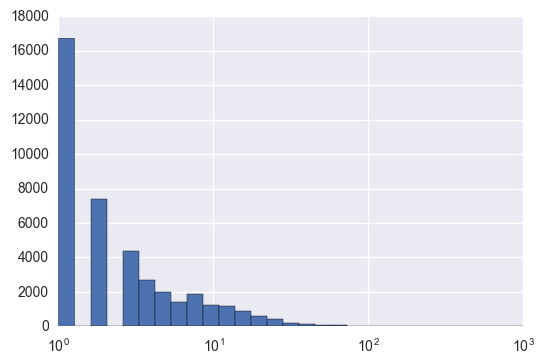

In [22]:
plt.hist(playlist_songs.groupby('playlist_id').size(), bins=np.logspace(0, 3, 30))
plt.xscale('log')

pd.merge(
    playlist_songs.query('playlist_id == 4'),
    songs,
    on='song_id')

In [23]:
songs.song_id.describe()

count    3168.000000
mean     1583.500000
std       914.667153
min         0.000000
25%       791.750000
50%      1583.500000
75%      2375.250000
max      3167.000000
Name: song_id, dtype: float64

In [24]:
playlist_songs.song_id.describe()

count    175911.000000
mean       1532.231151
std        1016.879762
min           0.000000
25%         541.000000
50%        1579.000000
75%        2505.000000
max        3167.000000
Name: song_id, dtype: float64

## Skip-gram generator

Generating all pairs of co-played words (ie artists) from the same context (ie playlist), without taking into account the order.

In [26]:
from itertools import permutations, chain

song_ids = playlist_songs.query('playlist_id == 3').song_id.values

def artist_skip_grams(song_ids):
    song_artist_ids = songs.artist_id.loc[song_ids].values
    return [(a1, a2) for a1, a2 in permutations(song_artist_ids, 2) if a1 != a2]

print(songs.artist_id.loc[song_ids])
print(artist_skip_grams(song_ids))

song_id
9      965
10     394
11    1264
Name: artist_id, dtype: int16
[(965, 394), (965, 1264), (394, 965), (394, 1264), (1264, 965), (1264, 394)]


In [27]:
from itertools import islice, repeat

class PlaylistToArtistSkipGrams:

    def __init__(self, playlists=playlists, loops=1):
        all_artist_skip_grams = chain.from_iterable(map(artist_skip_grams, playlists.songs.values))
        self.all_artist_skip_grams_iterable = chain.from_iterable(repeat(all_artist_skip_grams, loops))
        
    def next_batch(self, batch_size):
        next_skip_grams = list(islice(self.all_artist_skip_grams_iterable, batch_size))
        return np.array(next_skip_grams, dtype=np.int32) 

skipGramGenerator = PlaylistToArtistSkipGrams()

In [28]:
#%timeit sum(1 for _ in PlaylistToArtistSkipGrams().all_artist_skip_grams_iterable)

In [30]:
PlaylistToArtistSkipGrams(playlists=playlists, loops=1).next_batch(10)

array([[ 474,  960],
       [ 474, 1098],
       [ 474, 1264],
       [ 474, 1304],
       [ 474,  553],
       [ 474, 1308],
       [ 474, 1054],
       [ 474,  707],
       [ 960,  474],
       [ 960, 1098]], dtype=int32)

## Tensorflow model

In [32]:
N_SONGS = songs.song_id.max() + 1
N_ARTISTS = songs.artist_id.max() + 1

class Song2Vec:
    def __init__(self, n_entities, dimensionality=50, batch_size=None):
        
        with tf.name_scope('input_embeddings'):
            input_embeddings = tf.Variable(tf.random_normal([n_entities, dimensionality], 
                                                           stddev=0.01, mean=0), name='input')
            tf.histogram_summary('input_embeddings', input_embeddings)

        with tf.name_scope('output_embeddings'):
            output_embeddings = tf.Variable(tf.random_normal([n_entities, dimensionality], stddev=0.01, mean=0), name='output')
            tf.histogram_summary('output_embeddings', output_embeddings)

        with tf.name_scope('output_bias'):
            output_biases = tf.Variable(tf.random_normal([n_entities], stddev=0.01, mean=0), name='output_bias')
            tf.histogram_summary('output_biases', output_biases)
        
        self.n_entities = n_entities
        self.output_biases = output_biases
        self.input_embeddings = input_embeddings
        self.output_embeddings = output_embeddings
    
        self.input_song_ids = tf.placeholder(
            tf.int32, shape=[batch_size], name='input_song_ids')
        self.output_song_ids = tf.placeholder(
            tf.int32, shape=[batch_size], name='output_song_ids')

    def input_to_all_output_logits(self):
        """
        The architecture is made of:
         * input nodes for the user_id, and associated weights or embeddings V_u
         * internal weights W_i and biases b_i for each items
        """
        return self.output_biases + tf.matmul(
                tf.nn.embedding_lookup(self.input_embeddings, self.input_song_ids),
                tf.transpose(self.output_embeddings), name='input_to_all_output_logits')

    def sampled_loss(self):
        with tf.name_scope('loss'):
            sample_losses = tf.nn.sampled_softmax_loss(
                biases=self.output_biases,
                inputs=tf.nn.embedding_lookup(self.input_embeddings, self.input_song_ids),
                labels=tf.reshape(self.output_song_ids, (-1, 1)),
                weights=self.output_embeddings,
                num_classes=self.n_entities,
                num_sampled=10, num_true=1)
            return tf.reduce_mean(sample_losses)
        
    def exact_loss(self):
        with tf.name_scope('loss'):
            cross_entropy_sum = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.input_to_all_output_logits(),
                    labels=self.output_song_ids))
        return cross_entropy_sum

In [34]:
def save_embeddings_metadata(model, summary_writer):
    """ From https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/index.html#tensorboard-embedding-visualization
    """
    embeddings_metadata_path = os.path.join(LOG_DIR, 'artist_embeddings.tsv')
    artists.to_csv(embeddings_metadata_path, sep='\t')

    config = projector.ProjectorConfig()
    for embeddings_variable in [model.output_embeddings, model.input_embeddings]:
        embedding = config.embeddings.add()
        embedding.tensor_name = embeddings_variable.name
        embedding.metadata_path = embeddings_metadata_path
    
    projector.visualize_embeddings(summary_writer, config)

In [35]:
import datetime as dt
import os

from tensorflow.contrib.tensorboard.plugins import projector

LEARNING_RATE = 0.005
BATCH_SIZE = 10000
N_ITER = 100
LOG_DIR = '/tmp/tf_logs'

with tf.Graph().as_default():
    model = Song2Vec(n_entities=N_ARTISTS, dimensionality=20)
    loss = model.exact_loss()    #.sampled_loss()
    
    tf.scalar_summary('batch_loss', loss)
    summary = tf.merge_all_summaries()
    test_summary = tf.scalar_summary('test_loss', loss)
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    test_generator = PlaylistToArtistSkipGrams(playlists=test_playlists, loops=100)
    skip_grams_generator = PlaylistToArtistSkipGrams(loops=100)
    
    def perform_step(step, summary_writer):
        batch_input_and_output_ids = skip_grams_generator.next_batch(BATCH_SIZE)
        if batch_input_and_output_ids is None or len(batch_input_and_output_ids) == 0:
            print(batch_input_and_output_ids)
            return
        _, loss_value, summary_value = sess.run(
            fetches=[train_step, loss, summary], 
            feed_dict={
                model.input_song_ids: batch_input_and_output_ids[:, 0],
                model.output_song_ids: batch_input_and_output_ids[:, 1]
            })
        summary_writer.add_summary(summary_value, global_step=step)
        
        if step% 10 == 0:
            test_input_and_output_ids = test_generator.next_batch(BATCH_SIZE * 10)
            test_loss_value, test_summary_value = sess.run(
            fetches=[loss, test_summary], 
            feed_dict={
                model.input_song_ids: test_input_and_output_ids[:, 0],
                model.output_song_ids: test_input_and_output_ids[:, 1]
            })

            print('step {step}, batch_loss = {loss_value:.2f}, test_loss = {test_loss_value:.2f}'.format(**locals()))
            summary_writer.add_summary(test_summary_value, global_step=step)
        summary_writer.flush()

    with tf.Session() as sess:

        summary_writer = tf.train.SummaryWriter(
            os.path.join(LOG_DIR,'{:%Y%m%d%H%M%S}'.format(dt.datetime.now())),
            sess.graph)

        sess.run(tf.global_variables_initializer())
        
        for step in range(N_ITER):
            perform_step(step, summary_writer)
        
        input_embeddings = model.input_embeddings.eval()
        output_embeddings = model.output_embeddings.eval()
        
        saver = tf.train.Saver()
        saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)
        save_embeddings_metadata(model, summary_writer)

step 0, batch_loss = 7.19, test_loss = 7.18
step 10, batch_loss = 7.10, test_loss = 7.03
step 20, batch_loss = 6.86, test_loss = 6.40
step 30, batch_loss = 5.73, test_loss = 6.51
step 40, batch_loss = 6.58, test_loss = 5.40
step 50, batch_loss = 5.22, test_loss = 5.12
step 60, batch_loss = 5.80, test_loss = 5.11
step 70, batch_loss = 4.88, test_loss = 4.63
step 80, batch_loss = 4.22, test_loss = 4.92
step 90, batch_loss = 4.71, test_loss = 4.87


In [36]:
pd.DataFrame(input_embeddings).to_csv(os.path.join(LOG_DIR, "input_embeddings.tsv"), sep='\t', index=None, header=None)
pd.DataFrame(output_embeddings).to_csv(os.path.join(LOG_DIR, "output_embeddings.tsv"), sep='\t', index=None, header=None)

In [37]:
from IPython.core.display import HTML, display
import pandas as pd

pd.set_option('display.width', 1000)

from scipy import spatial

def embeddings_to_distances(embeddings):
    item_item_distances = pd.DataFrame(
        index=embeddings.index,
        columns=embeddings.index,
        data=spatial.distance.squareform(spatial.distance.pdist(embeddings.values, metric='cosine'))
    )
    return item_item_distances

def topn_most_similar(item_id, topn, item_item_distances):
    candidate_distances = item_item_distances.loc[item_id]
    return candidate_distances.sort_values().iloc[1:(topn+1)].to_frame('distance')

def display_items(from_id, to_items_df, items_metadata):
    display(HTML(items_metadata.loc[[from_id]].to_html()))
    display(HTML(to_items_df.join(items_metadata).to_html()))
    
def display_topn_most_similar(item_id, distances, topn, items_metadata):
    most_similar = topn_most_similar(item_id, topn, distances)
    display_items(item_id, most_similar, items_metadata)

In [38]:
distances = embeddings_to_distances(pd.DataFrame(data=input_embeddings))
distances = embeddings_to_distances(pd.DataFrame(data=output_embeddings))

In [39]:
ABBA = 19
display_topn_most_similar(item_id=ABBA, distances=distances, topn=5, items_metadata=artists)

,artist_id,artist,n_songs_played
19,19,Abba,39


,distance,artist_id,artist,n_songs_played
500,0.001802,500,Howard Jones,21
487,0.002517,487,Heatwave,21
1231,0.003059,1231,Tom Cochrane,42
271,0.003455,271,Crowded House,31
983,0.003458,983,Rupert Holmes,41


In [40]:
WITNEY = 1300
display_topn_most_similar(item_id=WITNEY, distances=distances, topn=5, items_metadata=artists)

,artist_id,artist,n_songs_played
1300,1300,Whitney Houston,21


,distance,artist_id,artist,n_songs_played
150,0.000646,150,Boney James & Rick Braun,21
1176,0.000763,1176,The Monkees,20
652,0.000773,652,Kim Waters,39
1253,0.000815,1253,Trin-I-Tee,43
145,0.000819,145,Bobby Helms,21


In [41]:
TWOPAC = 3
display_topn_most_similar(item_id=TWOPAC, distances=distances, topn=5, items_metadata=artists)

,artist_id,artist,n_songs_played
3,3,2Pac,146


,distance,artist_id,artist,n_songs_played
80,0.012453,80,Baby Bash,132
1008,0.016264,1008,Sean Kingston,164
1096,0.017437,1096,T-Pain,129
623,0.017870,623,Kanye West & Jay-Z,134
695,0.019872,695,Lil' Jon & The Eastside Boyz,110


In [42]:
BEATLES = 1129
#output_distances = embeddings_to_distances(pd.DataFrame(data=output_embeddings))
display_topn_most_similar(item_id=BEATLES, distances=distances, topn=10, items_metadata=artists)

,artist_id,artist,n_songs_played
1129,1129,The Beatles,105


,distance,artist_id,artist,n_songs_played
1153,0.002826,1153,The Electric Light Orchestra,83
1093,0.003196,1093,Supertramp,88
1239,0.003222,1239,Toto,41
82,0.003654,82,Bachman-Turner Overdrive,104
453,0.004068,453,Golden Earring,55
1163,0.004253,1163,The Guess Who,59
1070,0.004829,1070,Steppenwolf,88
1257,0.005047,1257,Twisted Sister,33
897,0.005140,897,Peter Frampton,71
69,0.005580,69,Autograph,28


In [43]:
ROLLING = 1190
display_topn_most_similar(item_id=ROLLING, distances=distances, topn=10, items_metadata=artists)

,artist_id,artist,n_songs_played
1190,1190,The Rolling Stones,375


,distance,artist_id,artist,n_songs_played
608,0.008029,608,Judas Priest,138
1170,0.008336,1170,The Jimi Hendrix Experience,237
984,0.009725,984,Rush,226
311,0.012075,311,Def Leppard,418
1111,0.014140,1111,Temple Of The Dog,76
1004,0.015173,1004,Scorpions,191
696,0.016469,696,Limp Bizkit,52
756,0.016717,756,Marcy Playground,43
285,0.016823,285,Danzig,71
63,0.017309,63,Apocalyptica,148
